# Support Vector Machines

In this notebook, we will be discussing SVM (Support Vector Machines) as a solution to classification problems. Then we will build and train a model using human cell records and classify cells to whether the samples are benign or malignant.

It is inspired by IBM's course on Data Science.

# What is SVM?

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data is not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

Now the major part of the SVM for which it is most famous: the kernel trick. The kernel can be thought of as the way in which the hyperplane is formed. The reason it's important is that SVM can take non-linear kernels too.

**NOTE:** Selecting Kernels is important. It's recommended to try various kernels and see the best results. Hyperparameter tuning via Grid search is a good option for it. 

## Advantages

* SVM works relatively well when there is a clear margin of separation between classes.
* SVM is more effective in high dimensional spaces.
* SVM is effective in cases where the number of dimensions is greater than the number of samples.
* It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Support Vector Machines may be relatively sluggish when it comes to training especially with large datasets, however, when it comes to prediction they are quite fast.
* The hyperplane is affected by only the support vectors thus outliers have less impact.

## Disadvantages

* It doesn’t perform well when we have large data set because the required training time is higher
* Does not perform well in case of overlapped classes.
* SVM doesn’t directly provide probability estimates, these are calculated using an expensive five-fold cross-validation. It is included in the related SVC method of Python scikit-learn library.
* When it comes to Support Vector Machines, correct parameters can define the line between misery and victory. This makes Support Vector Machines difficult to implement sometimes.
* Selecting the appropriate kernel function can be tricky.

# Practical Example

Now, we are going to use it in a practical example. We would get a dataset and try to classify the cell as benign or malignant. 

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

First, let's do the imports.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load Data From CSV File


In [2]:
cell_df = pd.read_csv('Datasets/Cell Samples.csv')
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:


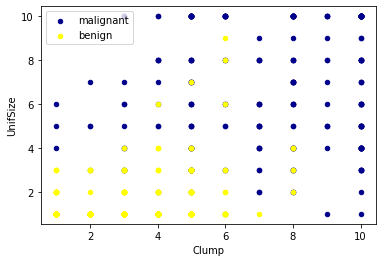

In [3]:
ax = cell_df[cell_df['Class'] == 4].plot(kind='scatter', x='Clump',
                                               y='UnifSize', color='DarkBlue',
                                               label='malignant');
cell_df[cell_df['Class'] == 2].plot(kind='scatter', x='Clump', y='UnifSize',
                                          color='Yellow', label='benign', ax=ax);
plt.show()

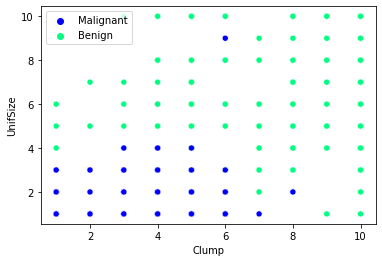

In [4]:
ax = sns.scatterplot(data=cell_df, x='Clump', y='UnifSize', hue='Class',
                     palette='winter')
L = ax.legend()
L.get_texts()[0].set_text('Malignant')
L.get_texts()[1].set_text('Benign')

## Data pre-processing and selection


Lets first look at columns data types:


In [5]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. We can drop those rows:


In [6]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [7]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh',
                      'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.


In [8]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y[0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset


Okay, we split our dataset into train and test set:


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


In [10]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

After being fitted, the model can then be used to predict new values:


In [11]:
yhat = clf.predict(X_test)
yhat[0:5]

array([2, 4, 2, 4, 2])

<h2 id="evaluation">Evaluation</h2>


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

<AxesSubplot:xlabel='Predicted', ylabel='True'>

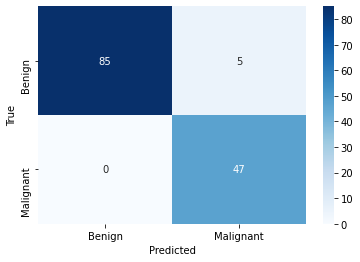

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true=y_test, y_pred=yhat)
cm_df = pd.DataFrame(cm,
                     index=pd.Index(['Benign', 'Malignant'], name='True'),
                     columns=pd.Index(['Benign', 'Malignant'], name='Predicted'))
sns.heatmap(cm_df, cmap='Blues', annot=True)

In [14]:
# Classification Report
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



You can also easily use the **f1_score** from sklearn library:


In [15]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.9639038982104676

Lets try jaccard index for accuracy:


In [16]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, pos_label=2)

0.9444444444444444

# Conclusion

It seems like a decent model. If you want, you can go ahead and use Grid Search or anything else to try out different kernels. 

# Author
By Abhinav Garg